# A model of multivariate Zero-Inflated Poisson emissions from a Hidden Markov Model for detecting change-points in count data

## Introduction

Consider the problem where discrete samples (e.g. counts) are generated by two or more processes over a given time period. The samples could come from a a wide range of processes that produce time-series data, e.g. the number of cars on a given set of roads in close proximity, the number of HTTP connections to multiple servers that host the same content, etc. 

A change-point occurs at an unknown time and lasts for an unknown duration. Furthermore, the dataset can contain zero or more changepoints. During the changepoint, all of the processes are affected simultaneously and the samples from the processes may increase or decrease in value compared to the normal case. In the aforementioned examples, the change-point could be due to a football match causing more traffic or due to a viral video causing more HTTP connections.

In the model described in this notebook, the processes are assumed to draw samples from Zero-Inflated Poisson (ZIP) distributions, however, the approach can be modified to take other parametric distributions. The ZIP model generates count data with an excess number of zeros compared to a standard Poisson distribution. It should be noted that the parameters of the ZIP distributions for each process are independent, thus permitting, for example, the means of the Poisson distributions to be drastically different.

Given two or more time-series datasets, the problem is to determine when the change-point occurs that affects the processes simultaneously. In addition, the parameters of the models for the processes in the normal and abnormal cases should be determined.

This Jupyter notebook explores how change-points in synthetic time-series data can be detected using a principled Bayesian approach using the R programming language. The inference is performed using the JAGS library (http://mcmc-jags.sourceforge.net/).

## Import the required R libraries

In [112]:
# Import the required libraries
library(dplyr)
library(ggplot2)
library(gtable)
library(grid)
library(MCMCvis)
library(rjags)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=8, repr.plot.height=4)

## Data generation

In this notebook, it is assumed that real data is not available, therefore it needs to be generated. This approach permits analysis to be readily performed on the quality of the anomaly detector. Clearly, the algorithm needs to be assessed on real data, but that's beyond the scope of this notebook, although the last section provides an overview of how this would be performed.

The basis of the model is a Hidden Markov Model (HMM) with two states, which are `normal` and `abnormal`. A $2 \times 2$ state transition matrix encodes the probability of moving from one state to another at a given timestep, e.g. from the normal state to the abnormal state. In the model implemented in the R code below, the state transition matrix is given by:

$$
S = \begin{bmatrix} 
    p_{normal \rightarrow normal}   & p_{normal \rightarrow abnormal} \\
    p_{abnormal \rightarrow normal} & p_{abnormal \rightarrow abnormal} 
\end{bmatrix}
$$

where $p_{s_1 \rightarrow s_2}$ is the probability of a state transition from state $s_1$ to $s_2$. The Markov chain that underpins the HMM requires a probability distribution over the initial state. This is encoded as:

$$
p_{initial} = [p_{initial}^{(n)}, p_{initial}^{(a)}]
$$

where $p_{initial}^{(n)}$ is the probability of chain starting in the normal case and $p_{initial}^{(a)}$ is the probability of starting in the abnormal case. There is a constraint that $p_{initial}^{(n)} + p_{initial}^{(a)} = 1$.

The Zero-Inflated Poisson (ZIP) model for a single process with a single state is parameterised by:

* $\pi$ = probability of an extra zero where $0 \leq \pi \leq 1$
* $\lambda$ = mean of the Poisson distribution where $\lambda > 0$

In the model, there are $M$ ZIP models where $M > 1$ and each process has two states. The ZIP distributions are parameterised as follows:

* $\pi_{normal}$ = $[\pi_0^{(n)}, \pi_1^{(n)}, ..., \pi_{M-1}^{(n)}]$ where $\pi_i^{(n)}$ is the probability of an extra zero in model $i$ in the normal case
* $\pi_{abnormal}$ = $[\pi_0^{(a)}, \pi_1^{(a)}, ..., \pi_{M-1}^{(a)}]$ where $\pi_i^{(a)}$ is the probability of an extra zero in model $i$ in the abnormal case
* $\lambda_{normal}$ = $[\lambda_0^{(n)},, \lambda_1^{(n)},, ..., \lambda_{M-1}^{(n)},]$ where $\lambda_i^{(n)},$ is the mean of the Poisson distribution in model $i$ in the normal case
* $\lambda_{abnormal}$ = $[\lambda_0^{(a)}, \lambda_1^{(a)}, ..., \lambda_{M-1}^{(a)}]$ where $\lambda_i^{(a)}$ is the mean of the Poisson distribution in model $i$ in the abnormal case

In the cells below of this Jupyter notebook in this section, synthetic data is now generated.

In [113]:
sample_from_vector = function(p) {
    # Generate an index from a vector of probabilities.
    # 
    # Args:
    #   p: Vector of probabilities (must sum to unity).
    #
    # Returns:
    #   Random index weighted by the probability.
    
    # Generate a random sample from a vector of probabilities
    stopifnot(length(p) >= 1)
    stopifnot(near(sum(p), 1))

    # Use the vector as the probability of each index
    one_hot = rmultinom(1, 1, p)
    idx = which(one_hot == 1)
    
    # Return the index
    return(idx)
}

sample_from_zip_distribution = function(pi, 
                                        lambda, 
                                        N) {
    # Sample from a Zero-Inflated Poisson (ZIP) distribution.
    #
    # Args:
    #   pi: Probability of an extra zero.
    #   lambda: Mean of the Poisson disribution (ignoring extra zeros).
    #   N: Number of samples to generate.
    # 
    # Returns:
    #   N samples from the ZIP distribution.
    
    # Preconditions
    stopifnot(0 <= pi & pi <= 1)  # Must be a valid probability
    stopifnot(lambda > 0)         # Mean of the Poisson distribution must be > 0
    
    # Vector of the mixture from which the sample will be drawn
    mixture = rbinom(N, 1, 1-pi)
    
    # Generate samples from a Poisson distribution
    comp_poisson = rpois(N, lambda)
    
    # Generate samples from the zero distributiokn
    comp_zeros = rep(0, N)
    
    # Generate and return the mixture
    mixture * comp_zeros + mixture * comp_poisson
}

In [114]:
model = function(p_initial, 
                 S, 
                 pi_normal, 
                 pi_abnormal, 
                 lambda_normal, 
                 lambda_abnormal, 
                 N) {
    # Generate samples for M time-series datasets from the model.
    #
    # Args:
    #   p_initial: Probability of the initial state [p_normal, p_abnormal].
    #   S: State transition matrix.
    #   pi_normal: Probability of extra zeros in the ZIP model for the normal case.
    #   pi_abnormal: Probability of extra zeros in the ZIP model for the abnormal case.
    #   lambda_normal: Mean of the Poisson distribution for the normal case.
    #   lambda_abnormal: Mean of the Poisson distribution for the abnormal case.
    #   N: Number of timesteps to generate.
    #
    # Returns:
    #   List of ground truth states and the sample values.
    
    # Preconditions
    stopifnot(all(0 <= p_initial & p_initial <= 1))      # Initial state must be a valid probability
    stopifnot(all(0 <= pi_normal & pi_normal <= 1))      # Probabilities of extra zeros for the normal case must be valid
    stopifnot(all(0 <= pi_abnormal & pi_abnormal <= 1))  # Probabilities of extra zeros for the abnormal case must be valid
    stopifnot(all(lambda_normal >= 0))                   # Poisson distribution means for the normal case must be valid
    stopifnot(all(lambda_abnormal >= 0))                 # Poisson distribution means for the abnormal case must be valid
    stopifnot(N > 0)                                     # Number of time steps must be valid
    stopifnot(length(pi_normal) == length(pi_abnormal))
    stopifnot(length(pi_normal) == length(lambda_normal))
    stopifnot(length(pi_normal) == length(lambda_abnormal))  
    
    # Number of processes
    n_processes = length(pi_normal)
    
    # Vector of (ground-truth) states for each time step
    states = rep(NaN, N)
    
    # Matrix of samples for the ZIP distributions (process x time step)
    samples = matrix(NaN, nrow=N, ncol=n_processes)

    # Walk through each timestep
    for (i in 1:N) {
        
        # Determine the hidden state of the Markov model
        if (i == 1) {
            # State is dependent on the probability of the initial state
            states[i] = sample_from_vector(p_initial)
        } else {
            # State is dependent on the previous state
            prev_row = states[i-1]
            states[i] = sample_from_vector(S[prev_row,])            
        }
        
        # Generate a sample from each process j at timestep i
        for (j in 1:n_processes) {
            
            # Probability of extra zeros
            pi = if (states[i] == 1) pi_normal[j] else pi_abnormal[j]
                
            # Mean of the Poisson distribution (without the extra zeros)
            lambda = if (states[i] == 1) lambda_normal[j] else lambda_abnormal[j]
            
            # Generate the ZIP sample for the j(th) process at the i(th) timestep
            samples[i,j] = sample_from_zip_distribution(pi, lambda, 1)
        }
        
    }
    
    # Return the ground-truth states and the samples
    list(states=states, samples=samples)
}

In [115]:
# Probability of the initial state (normal, abnormal) -- must sum to unity
p_initial = c(0.9, 0.1)

# State transition matrix
# row 1 refers to the 'normal' state
# row 2 refers to the 'abnormal' state
S = matrix(c(
    0.95, 0.05, 
    0.3, 0.7), nrow=2, byrow=TRUE)

# Probability of extra zeros for the normal and abnormal states
pi_normal = c(0.8, 0.9)
pi_abnormal = c(0.3, 0.4)

# Mean of the Poisson distributions for the normal and abnormal states
lambda_normal = c(5, 30)
lambda_abnormal = c(20, 100)

# Number of samples to generate
N = 100

# Generate the data
output = model(p_initial, S, pi_normal, pi_abnormal, lambda_normal, lambda_abnormal, N)

The data that was generated using the model is now shown. The `states` field is the ground-truth state where $1$ denotes `normal` and $2$ denotes `abnormal`. The `samples` field contains the count data for each stochastic process.

In [116]:
output

0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0
7,0
0,0
7,0


## Visualise synthetic data

The data generated by the model is now visualised. Data generated during the normal state is denoted by the black lines and the abnormal state by the blue lines. It should be noted that the ground-truth state just described is not available to the Bayesian algorithm, i.e. it has to infer this as well as the parameters of the ZIP distributions for each process in both states.

In the figure shown, note the correlation in the outliers caused during the abnormal state, i.e. the overlap in time of the blue lines. The purpose of the algorithm is to determine those correlated events.

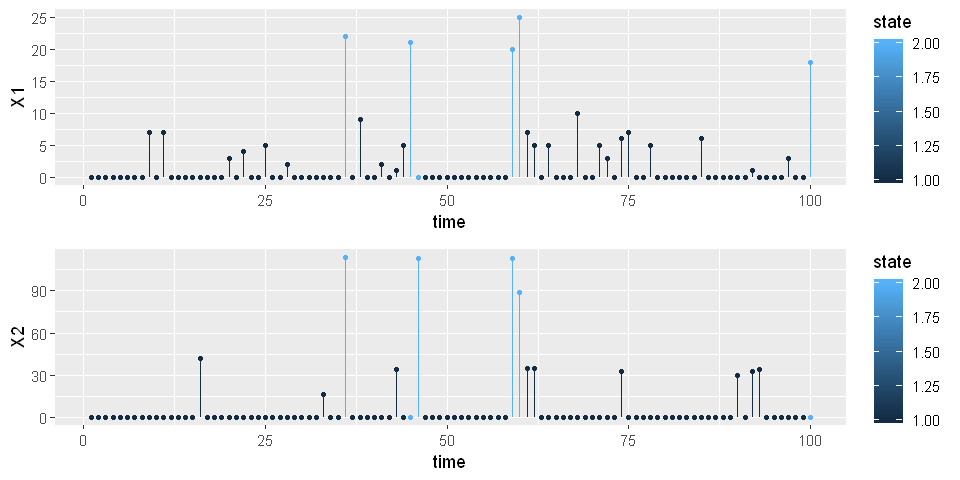

In [117]:
# Build a dataframe for plotting purposes
df = data.frame(time=1:N, state=output$states, output$samples)

# Plot the samples
library(gtable)
library(grid)

p1 = ggplot(df, aes(x=time, color=state)) +
    geom_point(aes(x=time,y=X1), size=1) +
    geom_segment(aes(time, X1, xend=time, yend=0))

p2 = ggplot(df, aes(x=time, color=state)) +
    geom_point(aes(x=time,y=X2), size=1) +
    geom_segment(aes(time, X2, xend=time, yend=0))

g1 = ggplotGrob(p1)
g2 = ggplotGrob(p2)
g = rbind(g1, g2, size="first") # stack the two plots
g$widths <- unit.pmax(g1$widths, g2$widths)  # use the largest widths
grid.draw(g)

## Bayesian inference of the parameters using JAGS

In this section, an MCMC approach is employed for infering the locations of the change-points, i.e. regions where the HMM is in the abnormal state, as well as the parameters of the models in each state.

### Run the Bayesian model

The Bayesian model is written using the JAGS language, which is remarkably similar to R by design.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 198
   Unobserved stochastic nodes: 307
   Total graph size: 1801

Initializing model



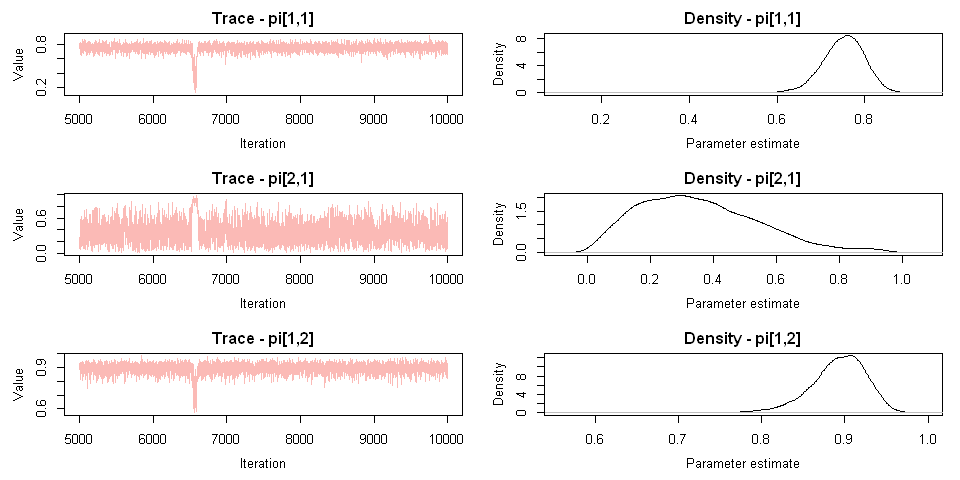

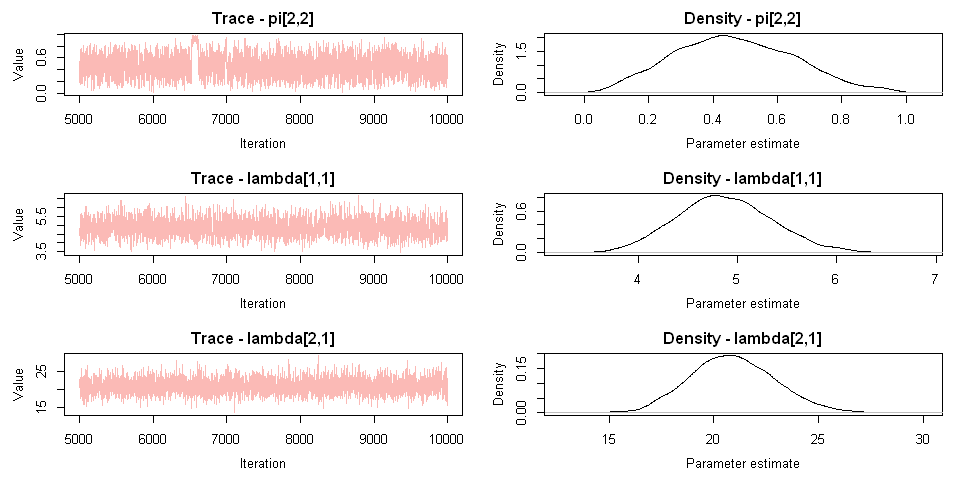

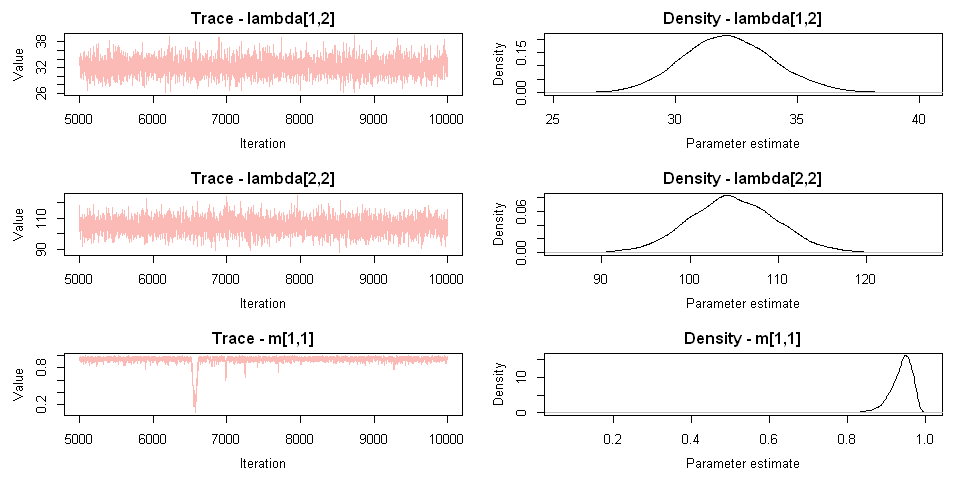

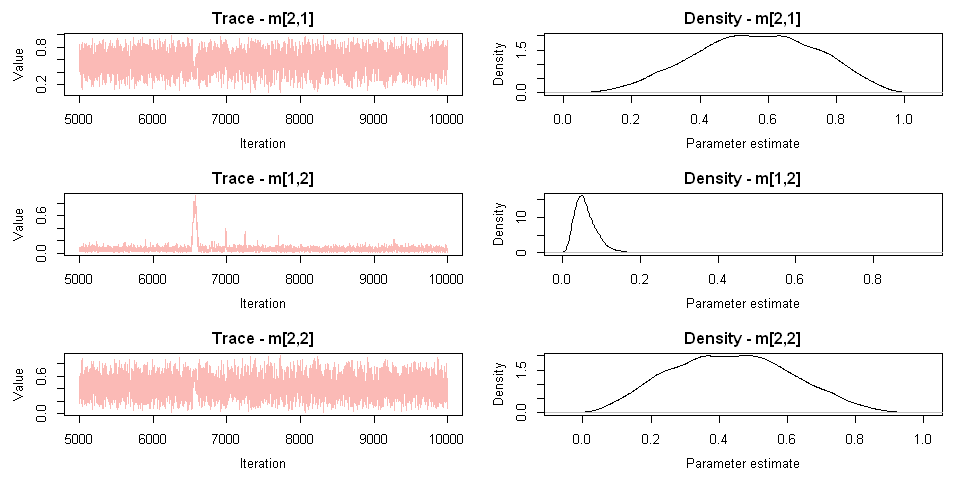

In [118]:
# Hidden Markov Model where the variables of each emissions are Zero-Inflated Poisson distributed
# 
# N = number of timesteps
# M = number of ZIP processes
# pi = 2 X M matrix of probabilities of extra zeros (normal and abnormal)
# lambda = 2 x M matrix of the means of the Poisson distributions
# 

model_string = "
model {

    # ----------------------------------------------------------------------------------
    # Priors
    # ----------------------------------------------------------------------------------

    for (j in 1:M) {
        
        # Priors for the probability of extra zeros in the normal and abnormal cases
        pi[1,j] ~ dbeta(1,1)  # normal
        pi[2,j] ~ dbeta(1,1)  # abnormal

        # Priors for the means of the Poisson distributions (excluding the extra zeros)
        lambda[1,j] ~ dexp(0.1)  # normal
        lambda[2,j] ~ dexp(0.1)  # abnormal
    }

    # Prior for the state transition matrix
    m[1,1:2] ~ ddirch(alpha)  # from state 1 (normal)
    m[2,1:2] ~ ddirch(alpha)  # from state 2 (abnormal)

    # ----------------------------------------------------------------------------------
    # Likelihood
    # ----------------------------------------------------------------------------------
    
    # Initial state is assumed to be known (to be normal)
    s[1] = 1

    # Likelihood for the remaining N-1 samples
    for (i in 2:N) {
        
        # Previous (hidden) state of the HMM
        prev_state[i] = s[i-1]

        # Current (hidden) state of the HMM
        s[i] ~ dcat(m[prev_state[i], 1:2])

        # Generate the samples for each variable based on the hidden state
        for (j in 1:M) {

            # Is the sample drawn from the zero-inflated part?
            zero[i,j] ~ dbern(pi[s[i], j])  # 1=>zero-inflated, 0=>poisson

            # Lambda of the Poisson distribution (the 1e-10 is because a value of zero won't work)
            lambda_zip[i,j] <- ((1-zero[i,j]) * lambda[s[i],j]) + (zero[i,j] * 1e-10)

            # Sample from the Poisson distribution where the mean has been 'modulated'
            y[i,j] ~ dpois(lambda_zip[i,j])
        }

    }
}
"

# N x M matrix of samples
y = output$samples

# Number of samples
N = dim(y)[1]

# Number of processes
M = dim(y)[2]

# Setup the model
model = jags.model(textConnection(model_string),
                   data = list(N=N, M=M, y=y, alpha=c(1, 1)))

update(model, 
       50000)

samp <- coda.samples(model, 
                     variable.names=c("pi", "lambda", "m", "s"), 
                     n.iter=10000)

# Order the ground-truth values
MCMCtrace(samp, 
          params=c("pi", "lambda", "m"),
          pdf=FALSE)

### Visualisation of the changepoints infered by Bayesian inference

Now that inference has been performed, the probability of the states (normal and abnormal) can be plotted.

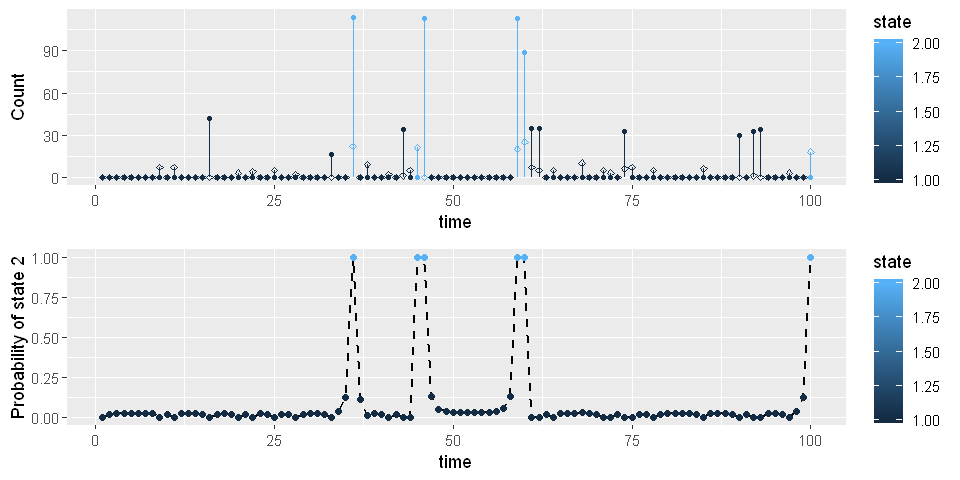

In [119]:
p_state_2 = function(x) {
    # Calculate the probability that the HMM is in state 2.
    length(which(x == 2)) / length(x)
}

# Calculate the state probability at each time step
samp_matrix = as.matrix(samp)
p_2 = rep(NA, N)
for (i in 1:N) {
    var = paste0("s[", i, "]")
    p_2[i] = p_state_2(samp_matrix[,var])
}

# Build a data frame containing the original data and the state probability
df2 = data.frame(time=1:N, state=output$states, y, p_2)

# 
p1 = ggplot(df2) +
    geom_point(aes(x=time,y=X1, color=state), size=1, shape=5) +
    geom_segment(aes(time, X1, xend=time, yend=0, color=state)) +
    geom_point(aes(x=time,y=X2, color=state), size=1) +
    geom_segment(aes(time, X2, xend=time, yend=0, color=state)) +
    ylab("Count")

p2 = ggplot(df2) +
    geom_line(aes(x=time, y=p_2), size=0.7, linetype="dashed") +
    geom_point(aes(x=time, y=p_2, color=state)) +
    ylab("Probability of state 2")

g1 = ggplotGrob(p1)
g2 = ggplotGrob(p2)

g = rbind(g1, g2, size="first") # stack the two plots
g$widths <- unit.pmax(g1$widths, g2$widths)  # use the largest widths
grid.draw(g)

The top part of the figure shows the input data as a function of time. Dataset 1 is plotted with empty diamonds and dataset 2 with filled circles. The samples are coloured based on the ground-truth state where black denotes normal and blue abnormal.

The bottom figure shows the probability that the data was generated by state 2. It should be noted that sometimes the inference algorithm doesn't know which state is which as currently modelled in JAGS. Therefore, the assignment of state 1 to normal and state 2 to abnormal is not necessarily the case. This issue needs to be explored and maybe due to a lack of a constraint.

If the algorithm is to be used for alerting people or another system, a threshold could be applied to the probability of the data being generated by a change-point. When the probability is above the threshold, an alert would be generated.

### Visualisation of the parameters of the processes

As well as inferring the change-points in the data, the Bayesian inference has to infer to the parameters of the ZIP distributions for both states for the all the processes. The results from the inference engine are now shown.

#### ZIP distribution

In [120]:
# Convert the samples from the inference engine into a data frame
df3 = as.data.frame(samp_matrix)

# Show the top of the data frame
head(df3)

"lambda[1,1]","lambda[2,1]","lambda[1,2]","lambda[2,2]","m[1,1]","m[2,1]","m[1,2]","m[2,2]","pi[1,1]","pi[2,1]",...,s[91],s[92],s[93],s[94],s[95],s[96],s[97],s[98],s[99],s[100]
5.561815,20.26780,33.91154,116.51138,0.9503388,0.3674356,0.04966119,0.6325644,0.7676008,0.2702719,...,1,1,1,1,1,1,1,1,1,2
4.800778,20.43862,32.04724,88.82827,0.9299956,0.5394247,0.07000439,0.4605753,0.7410430,0.2905165,...,1,1,1,1,1,1,1,1,1,2
4.931867,21.61866,32.49656,97.50127,0.9539427,0.5061888,0.04605727,0.4938112,0.6821615,0.4615980,...,1,1,1,1,1,1,1,1,1,2
5.006310,21.18030,33.16465,102.34107,0.9293173,0.3797701,0.07068270,0.6202299,0.8322078,0.5060308,...,1,1,1,1,1,1,1,1,1,2
5.006598,19.44279,33.39023,103.06650,0.9404338,0.3712124,0.05956616,0.6287876,0.7028751,0.6820343,...,1,1,1,1,1,1,1,1,1,2
4.287675,20.59879,33.79783,106.36567,0.9663468,0.3312577,0.03365323,0.6687423,0.7345698,0.5138152,...,1,1,1,1,1,1,1,1,1,2


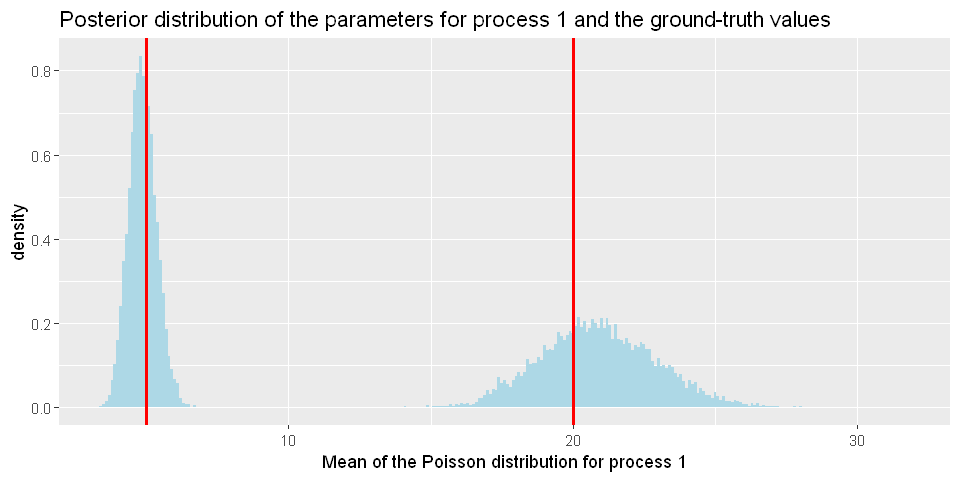

In [121]:
ggplot(df3) + 
    geom_histogram(aes(x=df3$"lambda[1,1]", y = ..density..), binwidth = 0.1, fill="lightblue") +
    geom_histogram(aes(x=df3$"lambda[2,1]", y = ..density..), binwidth = 0.1, fill="lightblue") +
    geom_vline(xintercept = lambda_abnormal[1], color = "red", size=1) +
    geom_vline(xintercept = lambda_normal[1], color = "red", size=1) +
    xlab("Mean of the Poisson distribution for process 1") +
    ggtitle("Posterior distribution of the parameters for process 1 and the ground-truth values")

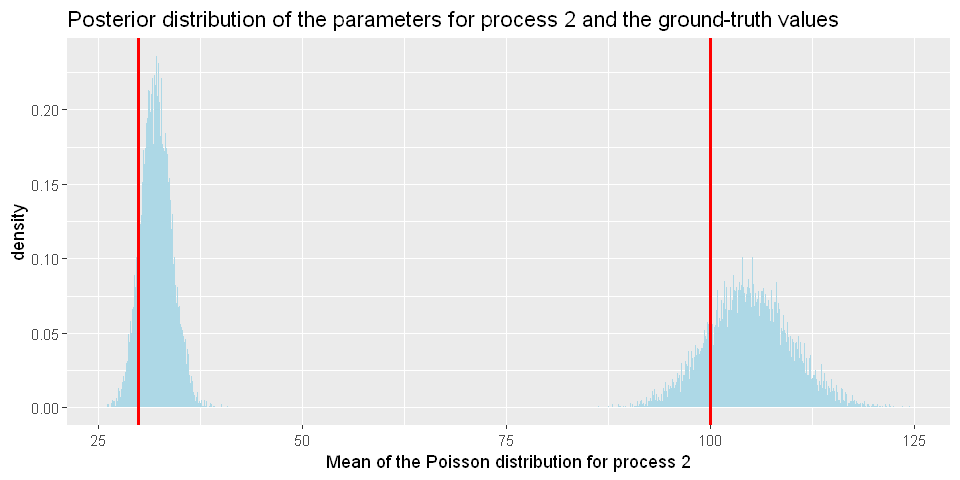

In [122]:
ggplot(df3) + 
    geom_histogram(aes(x=df3$"lambda[1,2]", y = ..density..), binwidth = 0.1, fill="lightblue") +
    geom_histogram(aes(x=df3$"lambda[2,2]", y = ..density..), binwidth = 0.1, fill="lightblue") +
    geom_vline(xintercept = lambda_abnormal[2], color = "red", size=1) +
    geom_vline(xintercept = lambda_normal[2], color = "red", size=1) +
    xlab("Mean of the Poisson distribution for process 2") +
    ggtitle("Posterior distribution of the parameters for process 2 and the ground-truth values")

#### State transition matrix

The ground-truth state transition matrix is:

In [123]:
S

0.95,0.05
0.30,0.70


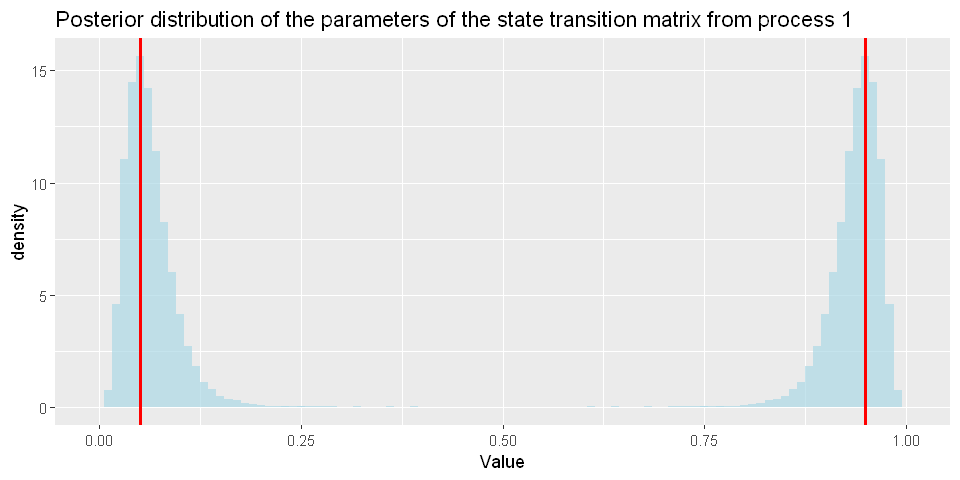

In [124]:
ggplot(df3) + 
    geom_histogram(aes(x=df3$"m[1,1]", y = ..density..), binwidth = 0.01, fill="lightblue", alpha = 0.7) +
    geom_histogram(aes(x=df3$"m[1,2]", y = ..density..), binwidth = 0.01, fill="lightblue", alpha = 0.7) +
    geom_vline(xintercept = S[1,1], color = "red", size=1) +
    geom_vline(xintercept = S[1,2], color = "red", size=1) +
    xlab("Value") +
    ggtitle("Posterior distribution of the parameters of the state transition matrix from process 1")

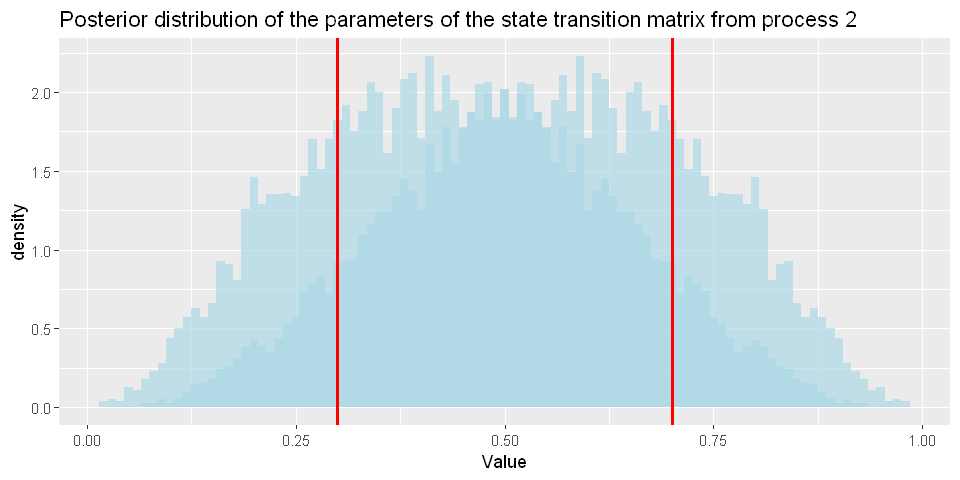

In [125]:
ggplot(df3) + 
    geom_histogram(aes(x=df3$"m[2,1]", y = ..density..), binwidth = 0.01, fill="lightblue", alpha = 0.7) +
    geom_histogram(aes(x=df3$"m[2,2]", y = ..density..), binwidth = 0.01, fill="lightblue", alpha = 0.7) +
    geom_vline(xintercept = S[2,1], color = "red", size=1) +
    geom_vline(xintercept = S[2,2], color = "red", size=1) +
    xlab("Value") +
    ggtitle("Posterior distribution of the parameters of the state transition matrix from process 2")

For some random datasets, the posterior distributions are actually close to the ground-truth if the process numbers are swapped over. This suggests that the constraint that the model starts in the normal case in the JAGS model needs to be explored further as there appears to be a bug or a lack of an additional constraint, e.g. that the Poisson distributions in the abnormal case have a higher mean.

## How to apply the algorithm to real data

The sections above have demonstrated that it is feasible to perform change-point detection on time-series data using synthetic data. Whilst only two processes were considered, the algorithm scales to multiple processes. The larger the dataset in both time and the number of processes that generated the data, the longer the inference will take to run. It may be necessary to use more efficient algorithms for infering the parameters in the HMM.

In order to apply this to real-world data, the following steps should be undertaken.

* The model described above assumes the data for each stochastic process for each state is drawn from a Zero-Inflated Poisson distribution. The first task is to check that the real data from each of the $M$ proceseses fits a ZIP model sufficiently well. If the data doesn't fit the model, a new parametric model will be required. Whilst a ZIP model has been used for each of the processes, it is possible to have different types of parametric models for each process, e.g. a Poisson process for one, a binomial process for another and a Bernoulli processs for yet another.

* Having determined the best model for each process, the JAGS model should be modified to reflect those changes.

* Run the JAGS model to infer the changepoints.

* Assess whether the changepoints are consistent with the real data. If the data is labelled by an expert, this task becomes a lot easier to perform and quantifiable results can be produced.